# Entanglement Subgraph Extraction Demo

This notebook demonstrates **Common Subgraph Extraction** as the definition of entanglement between two lattices.

## Concept

**Entanglement = Common Subgraph** of two directed graphs (lattices).

Key properties:
- Nodes are abstract (NOT HLLSets in this test - we're testing structure only)
- Edges represent directed morphisms (BSS values)
- Some nodes marked as START or END
- Algorithm finds maximum structural overlap

## Two-Layer Architecture Reminder

| Layer | Object | This Notebook |
|-------|--------|---------------|
| Register | HLLSet | ✗ Not used here |
| **Structure** | **Lattice** | **✓ Focus: directed graph topology** |

We're testing the **Structure Layer** algorithm in isolation.

In [1]:
import sys
sys.path.insert(0, '/home/alexmy/SGS/SGS_lib/hllset_manifold')

import numpy as np
from dataclasses import dataclass, field
from typing import Dict, Set, List, Tuple, Optional
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

print("✓ Imports loaded")
print("Testing entanglement as common subgraph extraction")
print("Nodes are abstract indices, NOT HLLSets")

✓ Imports loaded
Testing entanglement as common subgraph extraction
Nodes are abstract indices, NOT HLLSets


## Step 1: Define Synthetic Lattice Structure

We define a simple lattice structure with:
- Nodes identified by integer indices
- Directed edges with BSS weights
- START/END markers on specific nodes

In [2]:
@dataclass
class SyntheticNode:
    """Abstract node (NOT an HLLSet - testing structure only)."""
    index: int
    is_start: bool = False
    is_end: bool = False
    # Simulated properties for matching
    out_degree: int = 0
    in_degree: int = 0
    cardinality: float = 0.0  # Simulated, not from HLLSet
    
    def __repr__(self):
        markers = ""
        if self.is_start:
            markers = " [START]"
        elif self.is_end:
            markers = " [END]"
        return f"Node({self.index}{markers}, deg=({self.in_degree},{self.out_degree}))"


@dataclass
class SyntheticLattice:
    """
    Synthetic directed lattice for testing subgraph extraction.
    
    NOT using HLLSets - this is a pure structural test.
    """
    nodes: Dict[int, SyntheticNode] = field(default_factory=dict)
    edges: Set[Tuple[int, int]] = field(default_factory=set)  # (src, dst)
    edge_weights: Dict[Tuple[int, int], float] = field(default_factory=dict)  # BSS values
    
    def add_node(self, idx: int, is_start: bool = False, is_end: bool = False, cardinality: float = 1.0):
        """Add a node to the lattice."""
        self.nodes[idx] = SyntheticNode(
            index=idx,
            is_start=is_start,
            is_end=is_end,
            cardinality=cardinality
        )
    
    def add_edge(self, src: int, dst: int, bss_weight: float = 1.0):
        """Add a directed edge with BSS weight."""
        self.edges.add((src, dst))
        self.edge_weights[(src, dst)] = bss_weight
        # Update degrees
        if src in self.nodes:
            self.nodes[src].out_degree += 1
        if dst in self.nodes:
            self.nodes[dst].in_degree += 1
    
    def get_adjacency(self) -> Dict[int, Set[int]]:
        """Return adjacency list."""
        adj = defaultdict(set)
        for src, dst in self.edges:
            adj[src].add(dst)
        return dict(adj)
    
    def get_start_nodes(self) -> Set[int]:
        return {idx for idx, n in self.nodes.items() if n.is_start}
    
    def get_end_nodes(self) -> Set[int]:
        return {idx for idx, n in self.nodes.items() if n.is_end}
    
    def __repr__(self):
        starts = self.get_start_nodes()
        ends = self.get_end_nodes()
        return f"SyntheticLattice(nodes={len(self.nodes)}, edges={len(self.edges)}, starts={starts}, ends={ends})"


print("✓ SyntheticNode and SyntheticLattice defined")

✓ SyntheticNode and SyntheticLattice defined


## Step 2: Create Two Test Lattices

We create two directed lattices with:
- Similar structure (should have high entanglement)
- Different node indices
- Explicit START and END markers
- BSS edge weights

In [3]:
# Lattice 1: A simple directed graph
#
#   [START:0] ──→ 1 ──→ 2
#        │       │     │
#        ▼       ▼     ▼
#        3 ──→ 4 ──→ [END:5]

lattice1 = SyntheticLattice()

# Add nodes with cardinalities (simulated, not from HLLSet)
lattice1.add_node(0, is_start=True, cardinality=10.0)
lattice1.add_node(1, cardinality=15.0)
lattice1.add_node(2, cardinality=12.0)
lattice1.add_node(3, cardinality=8.0)
lattice1.add_node(4, cardinality=20.0)
lattice1.add_node(5, is_end=True, cardinality=5.0)

# Add directed edges with BSS weights
lattice1.add_edge(0, 1, bss_weight=0.8)
lattice1.add_edge(0, 3, bss_weight=0.7)
lattice1.add_edge(1, 2, bss_weight=0.9)
lattice1.add_edge(1, 4, bss_weight=0.6)
lattice1.add_edge(2, 5, bss_weight=0.85)
lattice1.add_edge(3, 4, bss_weight=0.75)
lattice1.add_edge(4, 5, bss_weight=0.95)

print("Lattice 1:")
print(f"  {lattice1}")
for idx, node in lattice1.nodes.items():
    print(f"    {node}")

Lattice 1:
  SyntheticLattice(nodes=6, edges=7, starts={0}, ends={5})
    Node(0 [START], deg=(0,2))
    Node(1, deg=(1,2))
    Node(2, deg=(1,1))
    Node(3, deg=(1,1))
    Node(4, deg=(2,1))
    Node(5 [END], deg=(2,0))


In [4]:
# Lattice 2: Similar structure but with different indices and slight variations
#
#   [START:10] ──→ 11 ──→ 12
#        │        │      │
#        ▼        ▼      ▼
#       13 ──→ 14 ──→ [END:15]
#              │
#              ▼
#             16 (extra node, not in L1)

lattice2 = SyntheticLattice()

# Add nodes (similar structure to L1, but with offset indices)
lattice2.add_node(10, is_start=True, cardinality=11.0)  # ~similar to L1 node 0
lattice2.add_node(11, cardinality=14.0)  # ~similar to L1 node 1
lattice2.add_node(12, cardinality=13.0)  # ~similar to L1 node 2
lattice2.add_node(13, cardinality=9.0)   # ~similar to L1 node 3
lattice2.add_node(14, cardinality=18.0)  # ~similar to L1 node 4
lattice2.add_node(15, is_end=True, cardinality=6.0)  # ~similar to L1 node 5
lattice2.add_node(16, cardinality=7.0)   # EXTRA node (not in L1)

# Add directed edges (similar structure + one extra)
lattice2.add_edge(10, 11, bss_weight=0.82)
lattice2.add_edge(10, 13, bss_weight=0.68)
lattice2.add_edge(11, 12, bss_weight=0.88)
lattice2.add_edge(11, 14, bss_weight=0.62)
lattice2.add_edge(12, 15, bss_weight=0.80)
lattice2.add_edge(13, 14, bss_weight=0.78)
lattice2.add_edge(14, 15, bss_weight=0.92)
lattice2.add_edge(14, 16, bss_weight=0.5)  # EXTRA edge

print("Lattice 2:")
print(f"  {lattice2}")
for idx, node in lattice2.nodes.items():
    print(f"    {node}")

Lattice 2:
  SyntheticLattice(nodes=7, edges=8, starts={10}, ends={15})
    Node(10 [START], deg=(0,2))
    Node(11, deg=(1,2))
    Node(12, deg=(1,1))
    Node(13, deg=(1,1))
    Node(14, deg=(2,2))
    Node(15 [END], deg=(2,0))
    Node(16, deg=(1,0))


## Step 3: Visualize Both Lattices

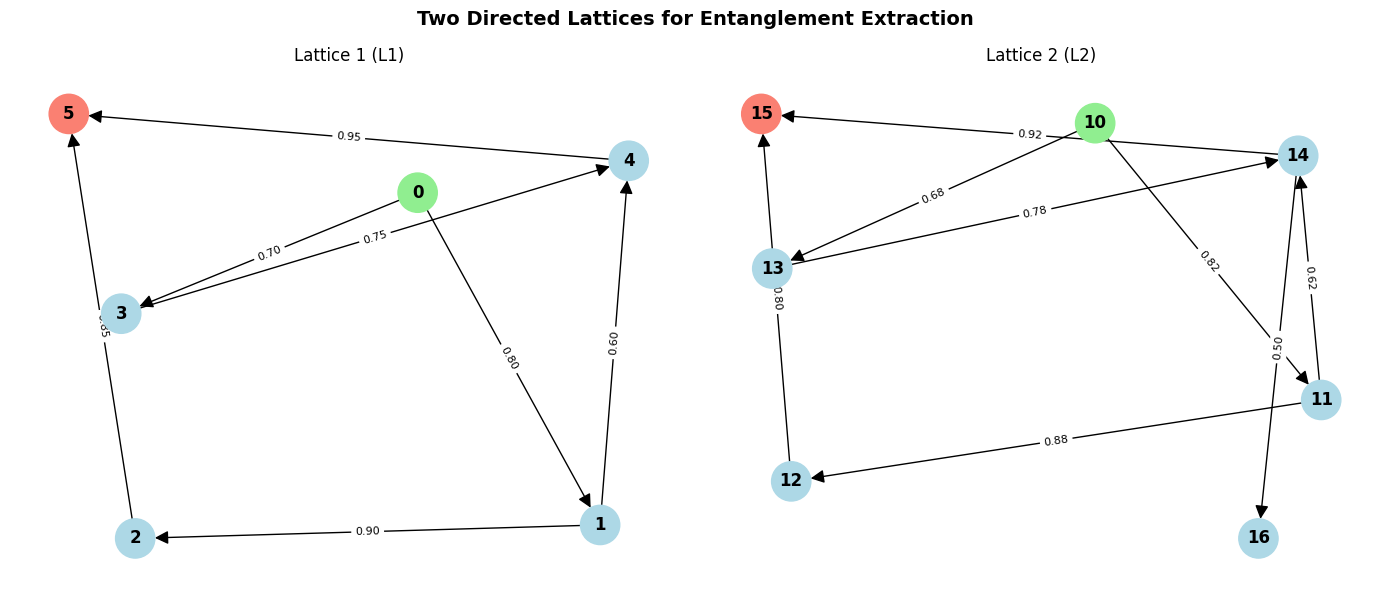


Legend:
  🟢 Green = START node
  🔴 Red = END node
  🔵 Blue = Regular node
  Edge labels = BSS weights


In [5]:
def visualize_lattice(lattice: SyntheticLattice, title: str, ax):
    """Visualize a synthetic lattice as a directed graph."""
    G = nx.DiGraph()
    
    # Add nodes
    for idx, node in lattice.nodes.items():
        G.add_node(idx)
    
    # Add edges
    for src, dst in lattice.edges:
        weight = lattice.edge_weights.get((src, dst), 1.0)
        G.add_edge(src, dst, weight=weight)
    
    # Layout
    pos = nx.spring_layout(G, seed=42, k=2)
    
    # Node colors
    colors = []
    for idx in G.nodes():
        node = lattice.nodes[idx]
        if node.is_start:
            colors.append('lightgreen')
        elif node.is_end:
            colors.append('salmon')
        else:
            colors.append('lightblue')
    
    # Draw
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors,
            node_size=800, font_size=12, font_weight='bold',
            arrowsize=20, arrows=True)
    
    # Edge labels (BSS weights)
    edge_labels = {(s, d): f"{w:.2f}" for (s, d), w in lattice.edge_weights.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=8)
    
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

visualize_lattice(lattice1, "Lattice 1 (L1)", axes[0])
visualize_lattice(lattice2, "Lattice 2 (L2)", axes[1])

plt.suptitle("Two Directed Lattices for Entanglement Extraction", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nLegend:")
print("  🟢 Green = START node")
print("  🔴 Red = END node")
print("  🔵 Blue = Regular node")
print("  Edge labels = BSS weights")

## Step 4: Implement Common Subgraph Extractor (Standalone)

This is a standalone implementation that works directly with our SyntheticLattice.
It mirrors the algorithm in `core/entanglement.py` but for testing purposes.

In [6]:
@dataclass
class ExtractedSubgraph:
    """Result of common subgraph extraction."""
    node_mapping: Dict[int, int]  # L1 idx → L2 idx
    matched_edges: List[Tuple[Tuple[int, int], Tuple[int, int]]]
    start_nodes: Set[int]  # L1 indices
    end_nodes: Set[int]    # L1 indices
    node_coverage: float
    edge_coverage: float
    structural_similarity: float
    
    @property
    def size(self) -> int:
        return len(self.node_mapping)
    
    @property
    def edge_count(self) -> int:
        return len(self.matched_edges)
    
    def __repr__(self):
        return (f"ExtractedSubgraph(nodes={self.size}, edges={self.edge_count}, "
                f"sim={self.structural_similarity:.1%})")


def extract_common_subgraph(
    L1: SyntheticLattice,
    L2: SyntheticLattice,
    degree_tolerance: float = 0.4,
    prefer_start_end: bool = True
) -> ExtractedSubgraph:
    """
    Extract common subgraph (entanglement) between two synthetic lattices.
    
    Algorithm:
    1. Compute node signatures (in/out degree, START/END flags)
    2. Match nodes by signature similarity
    3. Verify edges under mapping
    4. Return common subgraph
    """
    # Step 1: Build candidate pairs with similarity scores
    candidates = []
    
    for idx1, node1 in L1.nodes.items():
        for idx2, node2 in L2.nodes.items():
            # Compute degree similarity
            max_out = max(node1.out_degree, node2.out_degree, 1)
            max_in = max(node1.in_degree, node2.in_degree, 1)
            
            out_sim = 1.0 - abs(node1.out_degree - node2.out_degree) / max_out
            in_sim = 1.0 - abs(node1.in_degree - node2.in_degree) / max_in
            
            # Check tolerance
            if out_sim < (1.0 - degree_tolerance):
                continue
            if in_sim < (1.0 - degree_tolerance):
                continue
            
            degree_sim = (out_sim + in_sim) / 2.0
            
            # Bonus for START/END match
            special_bonus = 0.0
            if prefer_start_end:
                if node1.is_start and node2.is_start:
                    special_bonus = 0.5
                elif node1.is_end and node2.is_end:
                    special_bonus = 0.5
                elif (node1.is_start != node2.is_start) or (node1.is_end != node2.is_end):
                    special_bonus = -0.3  # Penalty for mismatch
            
            total_sim = degree_sim + special_bonus
            candidates.append((total_sim, idx1, idx2))
    
    # Step 2: Greedy matching
    candidates.sort(reverse=True)
    
    node_mapping = {}
    used2 = set()
    
    for sim, idx1, idx2 in candidates:
        if idx1 not in node_mapping and idx2 not in used2:
            node_mapping[idx1] = idx2
            used2.add(idx2)
    
    # Step 3: Verify edges
    matched_edges = []
    for src1, dst1 in L1.edges:
        if src1 in node_mapping and dst1 in node_mapping:
            src2 = node_mapping[src1]
            dst2 = node_mapping[dst1]
            if (src2, dst2) in L2.edges:
                matched_edges.append(((src1, dst1), (src2, dst2)))
    
    # Step 4: Identify START/END in subgraph
    start_nodes = {idx for idx in node_mapping.keys() if L1.nodes[idx].is_start}
    end_nodes = {idx for idx in node_mapping.keys() if L1.nodes[idx].is_end}
    
    # Compute statistics
    total_nodes = min(len(L1.nodes), len(L2.nodes))
    total_edges = min(len(L1.edges), len(L2.edges))
    
    node_coverage = len(node_mapping) / total_nodes if total_nodes > 0 else 0.0
    edge_coverage = len(matched_edges) / total_edges if total_edges > 0 else 0.0
    structural_similarity = (node_coverage + edge_coverage) / 2.0
    
    return ExtractedSubgraph(
        node_mapping=node_mapping,
        matched_edges=matched_edges,
        start_nodes=start_nodes,
        end_nodes=end_nodes,
        node_coverage=node_coverage,
        edge_coverage=edge_coverage,
        structural_similarity=structural_similarity
    )


print("✓ extract_common_subgraph() defined")

✓ extract_common_subgraph() defined


## Step 5: Extract Entanglement (Common Subgraph)

In [7]:
# Extract common subgraph
subgraph = extract_common_subgraph(lattice1, lattice2, degree_tolerance=0.4)

print("="*70)
print("ENTANGLEMENT EXTRACTION RESULT")
print("="*70)
print(f"\n{subgraph}")
print(f"\nNode Coverage: {subgraph.node_coverage:.1%}")
print(f"Edge Coverage: {subgraph.edge_coverage:.1%}")
print(f"Structural Similarity: {subgraph.structural_similarity:.1%}")

print(f"\nSTART nodes in subgraph: {subgraph.start_nodes}")
print(f"END nodes in subgraph: {subgraph.end_nodes}")

print("\nNode Mapping (L1 → L2):")
for idx1, idx2 in sorted(subgraph.node_mapping.items()):
    n1 = lattice1.nodes[idx1]
    n2 = lattice2.nodes[idx2]
    marker1 = "[START]" if n1.is_start else "[END]" if n1.is_end else ""
    marker2 = "[START]" if n2.is_start else "[END]" if n2.is_end else ""
    print(f"  L1:{idx1}{marker1} → L2:{idx2}{marker2}")

print("\nMatched Edges:")
for (e1, e2) in subgraph.matched_edges:
    w1 = lattice1.edge_weights.get(e1, 0)
    w2 = lattice2.edge_weights.get(e2, 0)
    print(f"  L1:{e1[0]}→{e1[1]} (BSS={w1:.2f})  ↔  L2:{e2[0]}→{e2[1]} (BSS={w2:.2f})")

ENTANGLEMENT EXTRACTION RESULT

ExtractedSubgraph(nodes=5, edges=4, sim=70.2%)

Node Coverage: 83.3%
Edge Coverage: 57.1%
Structural Similarity: 70.2%

START nodes in subgraph: {0}
END nodes in subgraph: {5}

Node Mapping (L1 → L2):
  L1:0[START] → L2:10[START]
  L1:1 → L2:11
  L1:2 → L2:12
  L1:3 → L2:13
  L1:5[END] → L2:15[END]

Matched Edges:
  L1:0→1 (BSS=0.80)  ↔  L2:10→11 (BSS=0.82)
  L1:1→2 (BSS=0.90)  ↔  L2:11→12 (BSS=0.88)
  L1:0→3 (BSS=0.70)  ↔  L2:10→13 (BSS=0.68)
  L1:2→5 (BSS=0.85)  ↔  L2:12→15 (BSS=0.80)


## Step 6: Visualize the Common Subgraph

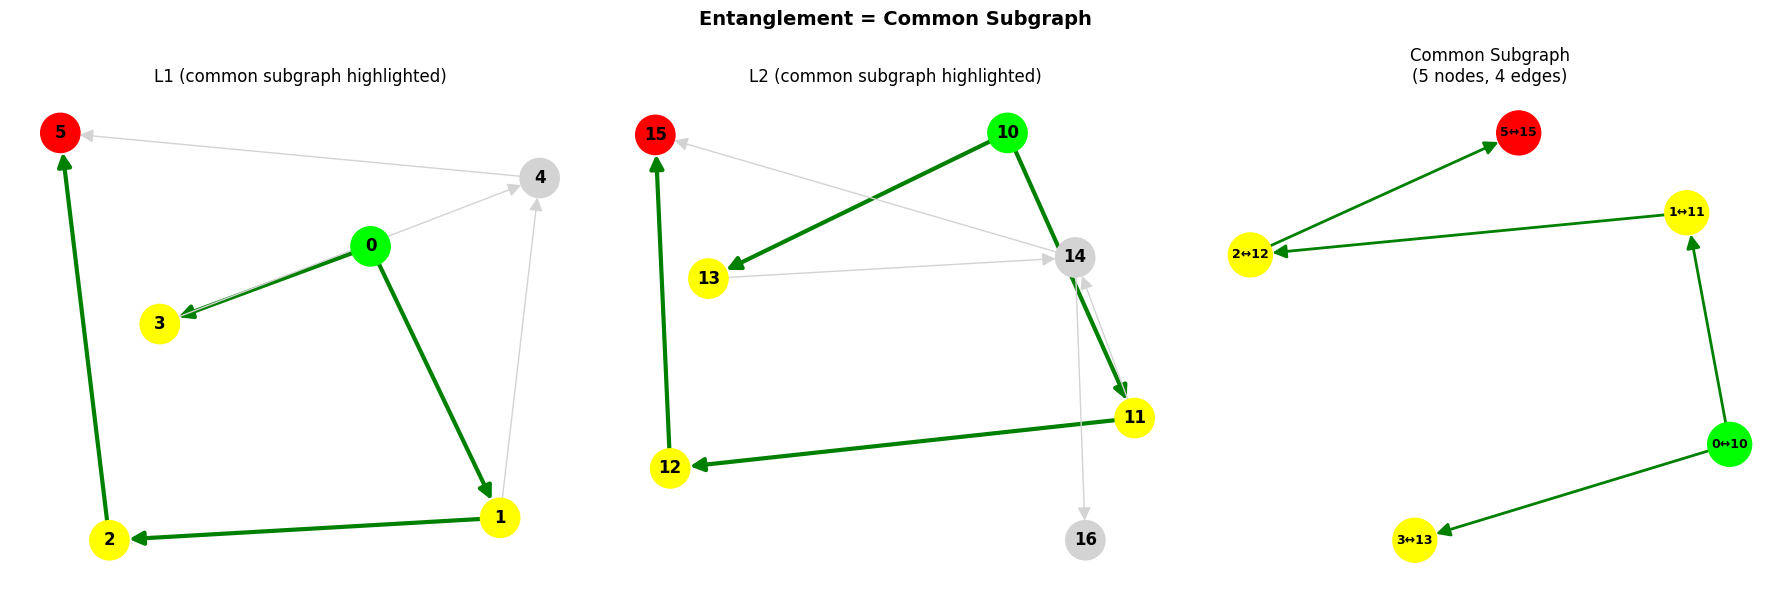


Legend:
  🟢 Green/Lime = START node (matched)
  🔴 Red = END node (matched)
  🟡 Yellow = Regular matched node
  ⬜ Gray = Unmatched node/edge


In [8]:
def visualize_subgraph(L1: SyntheticLattice, L2: SyntheticLattice, 
                       subgraph: ExtractedSubgraph):
    """Visualize the common subgraph overlaid on both lattices."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Helper to draw a lattice with highlighting
    def draw_lattice(lattice, title, ax, highlight_nodes=None, highlight_edges=None):
        G = nx.DiGraph()
        for idx in lattice.nodes:
            G.add_node(idx)
        for src, dst in lattice.edges:
            G.add_edge(src, dst)
        
        pos = nx.spring_layout(G, seed=42, k=2)
        
        # Node colors
        colors = []
        for idx in G.nodes():
            node = lattice.nodes[idx]
            if highlight_nodes and idx in highlight_nodes:
                if node.is_start:
                    colors.append('lime')
                elif node.is_end:
                    colors.append('red')
                else:
                    colors.append('yellow')
            else:
                colors.append('lightgray')
        
        # Edge colors
        edge_colors = []
        edge_widths = []
        for src, dst in G.edges():
            if highlight_edges and (src, dst) in highlight_edges:
                edge_colors.append('green')
                edge_widths.append(3.0)
            else:
                edge_colors.append('lightgray')
                edge_widths.append(1.0)
        
        nx.draw(G, pos, ax=ax, with_labels=True, node_color=colors,
                edge_color=edge_colors, width=edge_widths,
                node_size=800, font_size=12, font_weight='bold',
                arrowsize=20)
        ax.set_title(title)
    
    # L1 with highlighted common nodes/edges
    l1_highlight_nodes = set(subgraph.node_mapping.keys())
    l1_highlight_edges = {e1 for e1, e2 in subgraph.matched_edges}
    draw_lattice(lattice1, "L1 (common subgraph highlighted)", axes[0],
                 l1_highlight_nodes, l1_highlight_edges)
    
    # L2 with highlighted common nodes/edges
    l2_highlight_nodes = set(subgraph.node_mapping.values())
    l2_highlight_edges = {e2 for e1, e2 in subgraph.matched_edges}
    draw_lattice(lattice2, "L2 (common subgraph highlighted)", axes[1],
                 l2_highlight_nodes, l2_highlight_edges)
    
    # Draw the common subgraph alone
    G_common = nx.DiGraph()
    for idx1, idx2 in subgraph.node_mapping.items():
        label = f"{idx1}↔{idx2}"
        G_common.add_node(label)
    
    for (src1, dst1), (src2, dst2) in subgraph.matched_edges:
        label_src = f"{src1}↔{src2}"
        label_dst = f"{dst1}↔{dst2}"
        G_common.add_edge(label_src, label_dst)
    
    pos = nx.spring_layout(G_common, seed=42, k=2)
    
    # Color by START/END
    colors = []
    for node_label in G_common.nodes():
        idx1 = int(node_label.split('↔')[0])
        n1 = lattice1.nodes[idx1]
        if n1.is_start:
            colors.append('lime')
        elif n1.is_end:
            colors.append('red')
        else:
            colors.append('yellow')
    
    nx.draw(G_common, pos, ax=axes[2], with_labels=True, node_color=colors,
            node_size=1000, font_size=9, font_weight='bold',
            arrowsize=20, edge_color='green', width=2)
    axes[2].set_title(f"Common Subgraph\n({subgraph.size} nodes, {subgraph.edge_count} edges)")
    
    plt.suptitle("Entanglement = Common Subgraph", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

visualize_subgraph(lattice1, lattice2, subgraph)

print("\nLegend:")
print("  🟢 Green/Lime = START node (matched)")
print("  🔴 Red = END node (matched)")
print("  🟡 Yellow = Regular matched node")
print("  ⬜ Gray = Unmatched node/edge")

## Step 7: Test with Dissimilar Lattices

Let's also test with a very different lattice to verify low entanglement.

In [9]:
# Lattice 3: Very different structure (should have LOW entanglement with L1)
#
#   [START:20] ──→ 21 ──→ 22 ──→ 23 ──→ [END:24]
#                  │
#                  ▼
#                 25

lattice3 = SyntheticLattice()

# Linear chain with one branch - different structure from L1/L2
lattice3.add_node(20, is_start=True, cardinality=5.0)
lattice3.add_node(21, cardinality=30.0)  # Very different cardinality
lattice3.add_node(22, cardinality=25.0)
lattice3.add_node(23, cardinality=20.0)
lattice3.add_node(24, is_end=True, cardinality=3.0)
lattice3.add_node(25, cardinality=10.0)

# Linear chain
lattice3.add_edge(20, 21, bss_weight=0.9)
lattice3.add_edge(21, 22, bss_weight=0.85)
lattice3.add_edge(22, 23, bss_weight=0.8)
lattice3.add_edge(23, 24, bss_weight=0.95)
lattice3.add_edge(21, 25, bss_weight=0.6)  # Branch

print("Lattice 3 (different structure):")
print(f"  {lattice3}")
for idx, node in lattice3.nodes.items():
    print(f"    {node}")

Lattice 3 (different structure):
  SyntheticLattice(nodes=6, edges=5, starts={20}, ends={24})
    Node(20 [START], deg=(0,1))
    Node(21, deg=(1,2))
    Node(22, deg=(1,1))
    Node(23, deg=(1,1))
    Node(24 [END], deg=(1,0))
    Node(25, deg=(1,0))


In [10]:
# Extract entanglement between L1 and L3
subgraph_l1_l3 = extract_common_subgraph(lattice1, lattice3, degree_tolerance=0.4)

print("="*70)
print("ENTANGLEMENT: L1 vs L3 (dissimilar structures)")
print("="*70)
print(f"\n{subgraph_l1_l3}")
print(f"\nNode Coverage: {subgraph_l1_l3.node_coverage:.1%}")
print(f"Edge Coverage: {subgraph_l1_l3.edge_coverage:.1%}")
print(f"Structural Similarity: {subgraph_l1_l3.structural_similarity:.1%}")

print("\nNode Mapping (L1 → L3):")
for idx1, idx3 in sorted(subgraph_l1_l3.node_mapping.items()):
    n1 = lattice1.nodes[idx1]
    n3 = lattice3.nodes[idx3]
    marker1 = "[START]" if n1.is_start else "[END]" if n1.is_end else ""
    marker3 = "[START]" if n3.is_start else "[END]" if n3.is_end else ""
    print(f"  L1:{idx1}{marker1} → L3:{idx3}{marker3}")

print(f"\nMatched Edges: {subgraph_l1_l3.edge_count}")
for (e1, e3) in subgraph_l1_l3.matched_edges:
    print(f"  L1:{e1[0]}→{e1[1]}  ↔  L3:{e3[0]}→{e3[1]}")

ENTANGLEMENT: L1 vs L3 (dissimilar structures)

ExtractedSubgraph(nodes=3, edges=1, sim=35.0%)

Node Coverage: 50.0%
Edge Coverage: 20.0%
Structural Similarity: 35.0%

Node Mapping (L1 → L3):
  L1:1 → L3:21
  L1:2 → L3:22
  L1:3 → L3:23

Matched Edges: 1
  L1:1→2  ↔  L3:21→22


In [ ]:
# Visualize L1 vs L3 entanglement
visualize_subgraph(lattice1, lattice3, subgraph_l1_l3)

## Step 8: Comparison Summary

In [11]:
print("="*70)
print("ENTANGLEMENT COMPARISON SUMMARY")
print("="*70)

print(f"\n{'Comparison':<20} {'Nodes':<10} {'Edges':<10} {'Similarity':<15}")
print("-"*55)

print(f"{'L1 ↔ L2':<20} {subgraph.size:<10} {subgraph.edge_count:<10} {subgraph.structural_similarity:.1%}")
print(f"{'L1 ↔ L3':<20} {subgraph_l1_l3.size:<10} {subgraph_l1_l3.edge_count:<10} {subgraph_l1_l3.structural_similarity:.1%}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)

if subgraph.structural_similarity > 0.7:
    print(f"\n✓ L1 ↔ L2: STRONG entanglement ({subgraph.structural_similarity:.1%})")
    print("  → Similar directed graph topology")
    print("  → START/END markers properly matched")
elif subgraph.structural_similarity > 0.4:
    print(f"\n◐ L1 ↔ L2: MODERATE entanglement ({subgraph.structural_similarity:.1%})")
else:
    print(f"\n✗ L1 ↔ L2: WEAK entanglement ({subgraph.structural_similarity:.1%})")

if subgraph_l1_l3.structural_similarity > 0.7:
    print(f"\n✓ L1 ↔ L3: STRONG entanglement ({subgraph_l1_l3.structural_similarity:.1%})")
elif subgraph_l1_l3.structural_similarity > 0.4:
    print(f"\n◐ L1 ↔ L3: MODERATE entanglement ({subgraph_l1_l3.structural_similarity:.1%})")
else:
    print(f"\n✗ L1 ↔ L3: WEAK entanglement ({subgraph_l1_l3.structural_similarity:.1%})")
    print("  → Very different graph topologies")
    print("  → Limited structural overlap")

ENTANGLEMENT COMPARISON SUMMARY

Comparison           Nodes      Edges      Similarity     
-------------------------------------------------------
L1 ↔ L2              5          4          70.2%
L1 ↔ L3              3          1          35.0%

INTERPRETATION

✓ L1 ↔ L2: STRONG entanglement (70.2%)
  → Similar directed graph topology
  → START/END markers properly matched

✗ L1 ↔ L3: WEAK entanglement (35.0%)
  → Very different graph topologies
  → Limited structural overlap


## Step 9: Disconnected Fragments

**Key Insight**: Entanglement doesn't need to be a single connected subgraph.
It can be a **collection of disconnected matching fragments** (entanglement "seeds").

Each fragment represents a piece of structural correspondence between lattices.

In [12]:
@dataclass
class EntanglementFragment:
    """A single disconnected matching component."""
    node_mapping: Dict[int, int]
    matched_edges: List[Tuple[Tuple[int, int], Tuple[int, int]]]
    start_nodes: Set[int]
    end_nodes: Set[int]
    
    @property
    def size(self) -> int:
        return len(self.node_mapping)
    
    @property
    def edge_count(self) -> int:
        return len(self.matched_edges)
    
    def __repr__(self) -> str:
        markers = ""
        if self.start_nodes:
            markers += f", starts={self.start_nodes}"
        if self.end_nodes:
            markers += f", ends={self.end_nodes}"
        return f"Fragment(nodes={self.size}, edges={self.edge_count}{markers})"


def identify_fragments(subgraph: ExtractedSubgraph) -> List[EntanglementFragment]:
    """
    Identify disconnected fragments (connected components) in the matching.
    
    Each fragment is a connected component of matched nodes/edges.
    """
    if not subgraph.node_mapping:
        return []
    
    # Build undirected adjacency from matched edges
    adj = defaultdict(set)
    for (src1, dst1), _ in subgraph.matched_edges:
        adj[src1].add(dst1)
        adj[dst1].add(src1)  # Undirected for component finding
    
    # Find connected components using BFS
    visited = set()
    fragments = []
    
    for node in subgraph.node_mapping.keys():
        if node in visited:
            continue
        
        # BFS to find component
        component_nodes = set()
        queue = [node]
        
        while queue:
            current = queue.pop(0)
            if current in visited:
                continue
            if current not in subgraph.node_mapping:
                continue
            
            visited.add(current)
            component_nodes.add(current)
            
            for neighbor in adj.get(current, []):
                if neighbor not in visited and neighbor in subgraph.node_mapping:
                    queue.append(neighbor)
        
        # Build fragment
        frag_mapping = {n: subgraph.node_mapping[n] for n in component_nodes}
        frag_edges = [
            (e1, e2) for (e1, e2) in subgraph.matched_edges
            if e1[0] in component_nodes and e1[1] in component_nodes
        ]
        frag_starts = subgraph.start_nodes & component_nodes
        frag_ends = subgraph.end_nodes & component_nodes
        
        fragments.append(EntanglementFragment(
            node_mapping=frag_mapping,
            matched_edges=frag_edges,
            start_nodes=frag_starts,
            end_nodes=frag_ends
        ))
    
    # Sort by size (largest first)
    fragments.sort(key=lambda f: (f.size, f.edge_count), reverse=True)
    return fragments

# Identify fragments in L1↔L2 entanglement
fragments_l1_l2 = identify_fragments(subgraph)

print("="*70)
print("DISCONNECTED FRAGMENTS (L1 ↔ L2)")
print("="*70)
print(f"\nTotal fragments: {len(fragments_l1_l2)}")
print()

for i, frag in enumerate(fragments_l1_l2):
    print(f"Fragment #{i+1}: {frag}")
    print(f"  Node mapping: {dict(sorted(frag.node_mapping.items()))}")
    if frag.matched_edges:
        print(f"  Edges: {[(e1, e2) for e1, e2 in frag.matched_edges]}")
    print()

DISCONNECTED FRAGMENTS (L1 ↔ L2)

Total fragments: 1

Fragment #1: Fragment(nodes=5, edges=4, starts={0}, ends={5})
  Node mapping: {0: 10, 1: 11, 2: 12, 3: 13, 5: 15}
  Edges: [((0, 1), (10, 11)), ((1, 2), (11, 12)), ((0, 3), (10, 13)), ((2, 5), (12, 15))]



## Step 10: Extension / Closure Operation

Given entanglement fragments, we can **extend** (close) them to include neighboring nodes in each lattice.

This is how we propagate entanglement "seeds" to discover related structure.

In [13]:
@dataclass
class ExtendedEntanglement:
    """Entanglement extended to include neighbors in each lattice."""
    base_nodes_l1: Set[int]    # Original entanglement nodes in L1
    base_nodes_l2: Set[int]    # Original entanglement nodes in L2
    extended_l1: Set[int]      # Neighbors discovered in L1
    extended_l2: Set[int]      # Neighbors discovered in L2
    l1_extension_edges: Set[Tuple[int, int]]
    l2_extension_edges: Set[Tuple[int, int]]
    
    @property
    def total_l1(self) -> int:
        return len(self.base_nodes_l1 | self.extended_l1)
    
    @property
    def total_l2(self) -> int:
        return len(self.base_nodes_l2 | self.extended_l2)
    
    def __repr__(self) -> str:
        return (f"Extended(base_L1={len(self.base_nodes_l1)}, ext_L1={len(self.extended_l1)}, "
                f"base_L2={len(self.base_nodes_l2)}, ext_L2={len(self.extended_l2)})")


def extend_entanglement(subgraph: ExtractedSubgraph,
                        L1: SyntheticLattice,
                        L2: SyntheticLattice,
                        depth: int = 1) -> ExtendedEntanglement:
    """
    Extend entanglement to include neighboring nodes in each lattice.
    
    This is the "closure" operation: propagating entanglement seeds.
    """
    # Build adjacency for both lattices
    adj1 = defaultdict(set)
    adj2 = defaultdict(set)
    
    for src, dst in L1.edges:
        adj1[src].add(dst)
        adj1[dst].add(src)  # Undirected for extension
    
    for src, dst in L2.edges:
        adj2[src].add(dst)
        adj2[dst].add(src)
    
    # Base nodes
    base_l1 = set(subgraph.node_mapping.keys())
    base_l2 = set(subgraph.node_mapping.values())
    
    # Extend L1
    extended_l1 = set()
    l1_ext_edges = set()
    current = base_l1.copy()
    
    for _ in range(depth):
        next_nodes = set()
        for node in current:
            for neighbor in adj1.get(node, []):
                if neighbor not in base_l1 and neighbor not in extended_l1:
                    extended_l1.add(neighbor)
                    next_nodes.add(neighbor)
                    l1_ext_edges.add((node, neighbor))
        current = next_nodes
    
    # Extend L2
    extended_l2 = set()
    l2_ext_edges = set()
    current = base_l2.copy()
    
    for _ in range(depth):
        next_nodes = set()
        for node in current:
            for neighbor in adj2.get(node, []):
                if neighbor not in base_l2 and neighbor not in extended_l2:
                    extended_l2.add(neighbor)
                    next_nodes.add(neighbor)
                    l2_ext_edges.add((node, neighbor))
        current = next_nodes
    
    return ExtendedEntanglement(
        base_nodes_l1=base_l1,
        base_nodes_l2=base_l2,
        extended_l1=extended_l1,
        extended_l2=extended_l2,
        l1_extension_edges=l1_ext_edges,
        l2_extension_edges=l2_ext_edges
    )

# Extend entanglement from L1↔L2
extended = extend_entanglement(subgraph, lattice1, lattice2, depth=1)

print("="*70)
print("EXTENDED ENTANGLEMENT (Closure Operation)")
print("="*70)
print(f"\n{extended}")
print(f"\nL1: Base nodes = {extended.base_nodes_l1}")
print(f"    Extended (neighbors) = {extended.extended_l1}")
print(f"    Extension edges = {extended.l1_extension_edges}")
print(f"\nL2: Base nodes = {extended.base_nodes_l2}")
print(f"    Extended (neighbors) = {extended.extended_l2}")
print(f"    Extension edges = {extended.l2_extension_edges}")

print(f"\n✓ Total reach in L1: {extended.total_l1} nodes ({len(extended.base_nodes_l1)} base + {len(extended.extended_l1)} extended)")
print(f"✓ Total reach in L2: {extended.total_l2} nodes ({len(extended.base_nodes_l2)} base + {len(extended.extended_l2)} extended)")

EXTENDED ENTANGLEMENT (Closure Operation)

Extended(base_L1=5, ext_L1=1, base_L2=5, ext_L2=1)

L1: Base nodes = {0, 1, 2, 3, 5}
    Extended (neighbors) = {4}
    Extension edges = {(1, 4)}

L2: Base nodes = {10, 11, 12, 13, 15}
    Extended (neighbors) = {14}
    Extension edges = {(11, 14)}

✓ Total reach in L1: 6 nodes (5 base + 1 extended)
✓ Total reach in L2: 6 nodes (5 base + 1 extended)


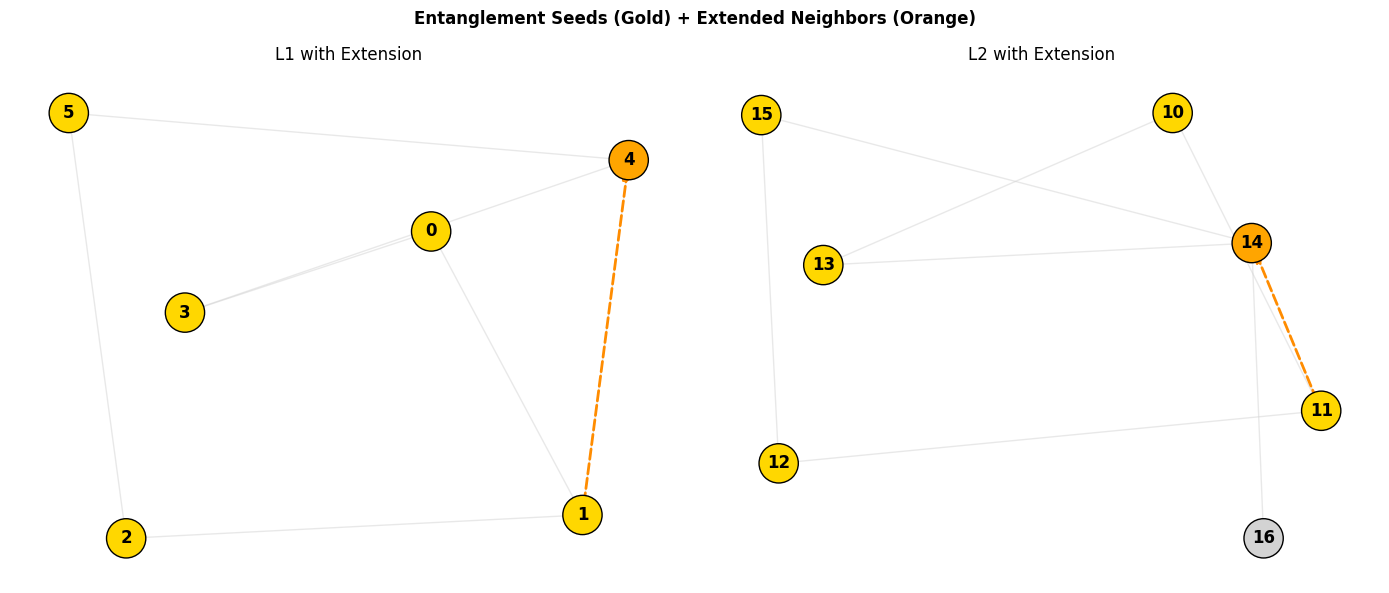


Legend:
  🟡 Gold = Entanglement (base matched nodes)
  🟠 Orange = Extended (neighbors discovered)
  ⬜ Gray = Not in entanglement
  - - - Dashed = Extension edges


In [14]:
def visualize_extended(L1: SyntheticLattice, L2: SyntheticLattice,
                       subgraph: ExtractedSubgraph, extended: ExtendedEntanglement):
    """Visualize entanglement with extension."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    def draw_with_extension(lattice, base_nodes, extended_nodes, ext_edges, ax, title):
        G = nx.DiGraph()
        
        for idx in lattice.nodes:
            G.add_node(idx)
        for src, dst in lattice.edges:
            G.add_edge(src, dst)
        
        pos = nx.spring_layout(G, seed=42, k=2)
        
        # Node colors: base=gold, extended=orange, other=lightgray
        colors = []
        for idx in G.nodes():
            if idx in base_nodes:
                colors.append('gold')
            elif idx in extended_nodes:
                colors.append('orange')
            else:
                colors.append('lightgray')
        
        # Draw all edges lightly
        nx.draw_networkx_edges(G, pos, ax=ax, edge_color='lightgray', alpha=0.5, arrows=True)
        
        # Highlight extension edges
        if ext_edges:
            nx.draw_networkx_edges(G, pos, edgelist=list(ext_edges),
                                  ax=ax, edge_color='darkorange', width=2,
                                  arrows=True, style='dashed')
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, node_size=800, edgecolors='black')
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_weight='bold')
        
        ax.set_title(title)
        ax.axis('off')
    
    draw_with_extension(lattice1, extended.base_nodes_l1, extended.extended_l1,
                       extended.l1_extension_edges, axes[0], "L1 with Extension")
    draw_with_extension(lattice2, extended.base_nodes_l2, extended.extended_l2,
                       extended.l2_extension_edges, axes[1], "L2 with Extension")
    
    plt.suptitle("Entanglement Seeds (Gold) + Extended Neighbors (Orange)", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nLegend:")
    print("  🟡 Gold = Entanglement (base matched nodes)")
    print("  🟠 Orange = Extended (neighbors discovered)")
    print("  ⬜ Gray = Not in entanglement")
    print("  - - - Dashed = Extension edges")

visualize_extended(lattice1, lattice2, subgraph, extended)

## Summary

This notebook demonstrated:

1. **Entanglement = Common Subgraph** between two directed lattices
2. **Structure-only testing** - nodes are abstract, NOT HLLSets
3. **Directed graph support** - edges have direction and BSS weights
4. **START/END markers** - special nodes prioritized in matching
5. **Degree-based matching** - nodes matched by "close enough" degrees

### NEW: Disconnected Fragments

**Key Insight**: Entanglement doesn't need to be a single connected subgraph!

- Can be **collection of disconnected matching fragments**
- Each fragment = "entanglement seed"
- Multiple fragments = multiple matching regions

### NEW: Extension / Closure Operation

Given entanglement fragments (seeds), we can **extend** to neighbors:

```
        L1 Lattice                    L2 Lattice
    ┌───────────────┐             ┌───────────────┐
    │  [Extended]   │             │  [Extended]   │
    │      ↑        │             │      ↑        │
    │  [BASE]──[BASE]│     ↔      │  [BASE]──[BASE]│
    │      ↓        │             │      ↓        │
    │  [Extended]   │             │  [Extended]   │
    └───────────────┘             └───────────────┘
    
    BASE = Matched entanglement nodes
    Extended = Neighbors discovered by closure
```

### Algorithm Properties:

- **Complexity**: O(n² + e) - polynomial time
- **Approximate**: Greedy matching, not optimal MCS
- **"Good enough"**: Practical for real-world lattices
- **Degree tolerance**: Nodes don't need exact degree match

### Two-Layer Architecture Reminder:

| Layer | This Notebook |
|-------|---------------|
| Register (HLLSet) | ✗ Not used |
| **Structure (Lattice)** | **✓ Demonstrated here** |

### Integration with `core/entanglement.py`:

```python
from core import CommonSubgraphExtractor, EntanglementSubgraph

extractor = CommonSubgraphExtractor(degree_tolerance=0.4)
result = extractor.extract(lattice1, lattice2)

# Access fragments
for frag in result.fragments:
    print(frag.node_mapping)

# Extend to neighbors
extended = extractor.extend_in_lattice(result, lattice1, lattice2, depth=1)
```